In [1]:
# load facebook prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet

import warnings
warnings.filterwarnings("ignore")

Importing plotly failed. Interactive plots will not work.


In [2]:
personal_income = pd.read_csv('PI.csv')

In [3]:
# convert to datetime
personal_income['DATE'] = pd.to_datetime(personal_income['DATE'])

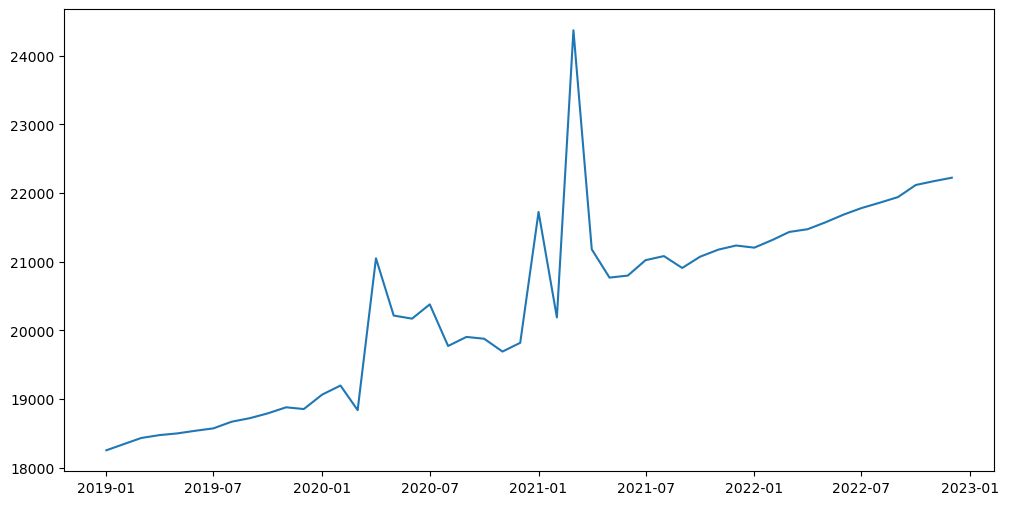

In [4]:
# plot the data
plt.figure(figsize=(12, 6))
plt.plot(personal_income['DATE'], personal_income['PI'])
plt.show()

In [5]:
# use prophet to impute missing values
# prophet requires the data to be in a specific format
# the data must have two columns: ds and y
# ds is the date column
# y is the value column
# rename the columns
personal_income = personal_income.rename(columns={'DATE': 'ds', 'PI': 'y'})

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.



Initial log joint probability = -58.2881
Iteration  1. Log joint probability =    67.0912. Improved by 125.379.
Iteration  2. Log joint probability =     127.04. Improved by 59.9487.
Iteration  3. Log joint probability =    150.248. Improved by 23.2083.
Iteration  4. Log joint probability =    151.948. Improved by 1.70031.
Iteration  5. Log joint probability =    152.054. Improved by 0.105823.
Iteration  6. Log joint probability =    152.094. Improved by 0.0396027.
Iteration  7. Log joint probability =    152.104. Improved by 0.00982299.
Iteration  8. Log joint probability =    152.207. Improved by 0.103197.
Iteration  9. Log joint probability =    152.292. Improved by 0.0852326.
Iteration 10. Log joint probability =    152.431. Improved by 0.138839.
Iteration 11. Log joint probability =    152.768. Improved by 0.336704.
Iteration 12. Log joint probability =    152.841. Improved by 0.0736255.
Iteration 13. Log joint probability =    152.866. Improved by 0.0247197.
Iteration 14. Log jo

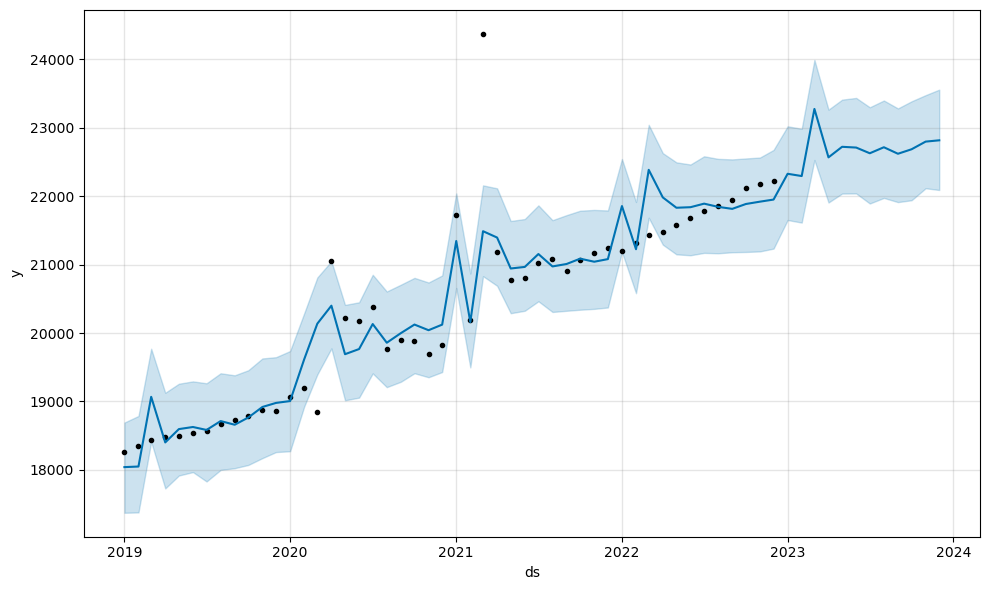

In [6]:
# create the prophet model
m = Prophet()

# fit the model
m.fit(personal_income)

# create a dataframe with the dates for which we want to make predictions
future = m.make_future_dataframe(periods=12, freq='MS')

# make predictions
forecast = m.predict(future)

# plot the predictions
m.plot(forecast)
plt.show()

### This is not a good model as it took into consideration of the stimulus check, which will be unlikey to occur again in the future months

In [7]:
# simple inputation with geometric growth rate
# calculate the growth rate
growth_rate = (personal_income['y'].iloc[-1] / personal_income['y'].iloc[0]) ** (1 / (len(personal_income) - 1))
growth_rate

1.0041958224776257

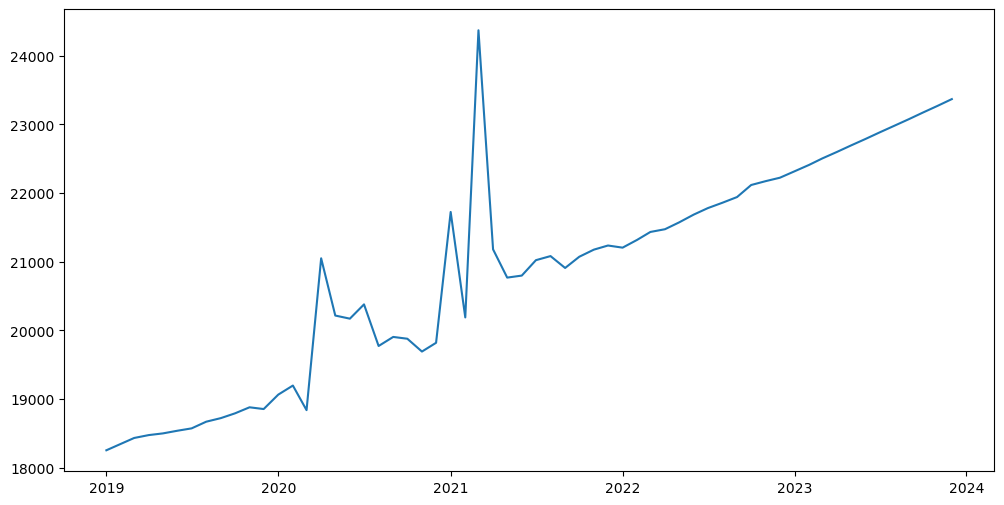

In [8]:
# reload the data
personal_income = pd.read_csv('PI.csv')

# convert to datetime
personal_income['DATE'] = pd.to_datetime(personal_income['DATE'])

for i in range(12):
    # calculate the new value
    new_value = personal_income['PI'].iloc[-1] * growth_rate
    # append the new value to the dataframe
    personal_income = personal_income.append({'DATE': personal_income['DATE'].iloc[-1] + pd.DateOffset(months=1), 'PI': new_value}, ignore_index=True)

# plot the data
plt.figure(figsize=(12, 6))
plt.plot(personal_income['DATE'], personal_income['PI'])
plt.show()

### Intuitively, this seems to be a better extrpolation

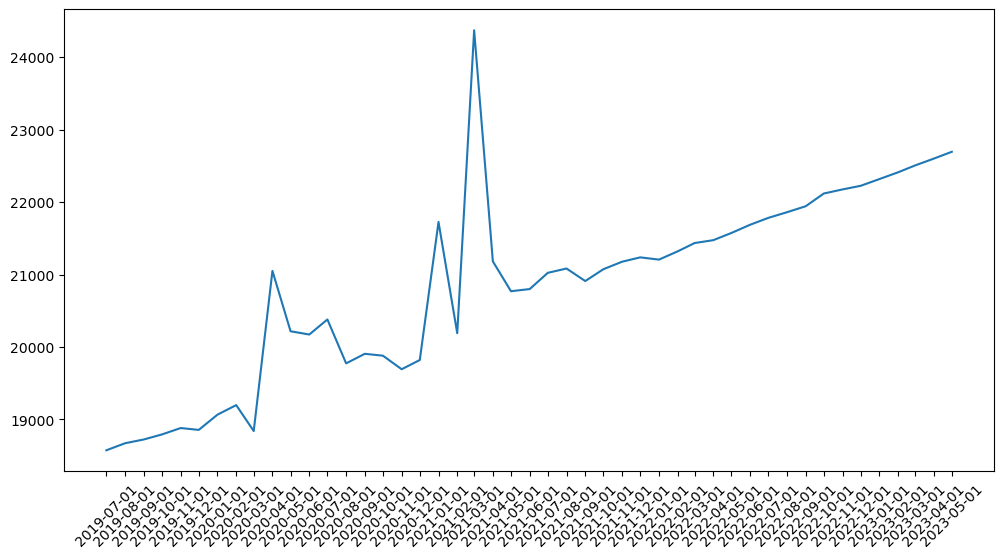

In [9]:
# limit the data from 2019-07 to 2023-05
personal_income = personal_income[(personal_income['DATE'] >= '2019-07-01') & (personal_income['DATE'] <= '2023-05-01')]
personal_income = personal_income.reset_index(drop=True)

# plot the data
plt.figure(figsize=(12, 6))
plt.plot(personal_income['DATE'], personal_income['PI'])
plt.xticks(ticks=personal_income['DATE'], rotation=45)
plt.show()

In [10]:
data_1d = personal_income['PI'].values
data_1d.shape

(47,)

In [11]:
# repeat the data to 3d with shape (47, 1, 3142) 
data_3d = np.repeat(data_1d[np.newaxis, :, np.newaxis], 3142, axis=0)
data_3d.shape

(3142, 47, 1)

In [12]:
# swap the axes to shape (47, 1, 3142) 
data_3d = np.swapaxes(data_3d, 0, 2)
data_3d = np.swapaxes(data_3d, 0, 1)
data_3d.shape

(47, 1, 3142)

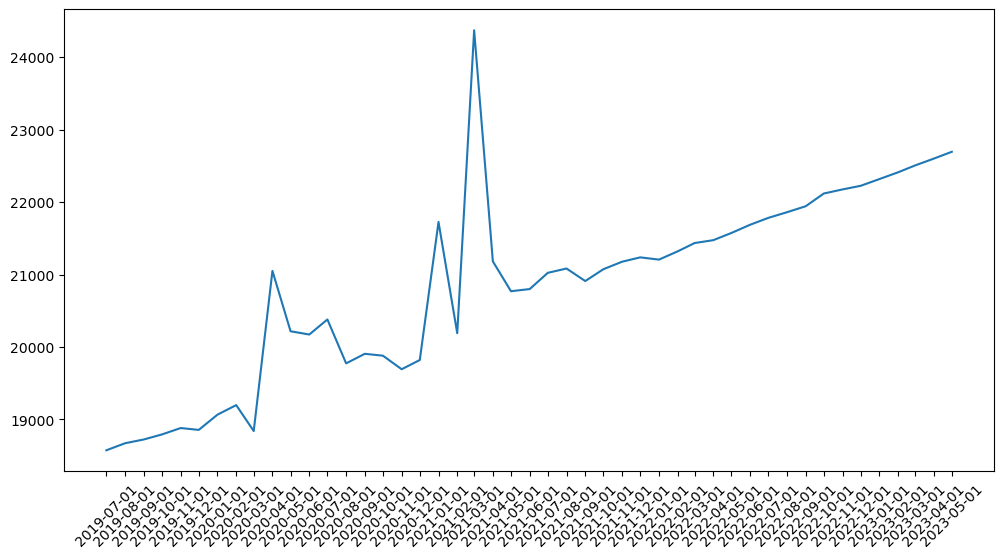

In [13]:
# slice into 1 county and plot
slice_1d = data_3d[:, :, 0]
plt.figure(figsize=(12, 6))
plt.plot(personal_income['DATE'], slice_1d)
plt.xticks(ticks=personal_income['DATE'], rotation=45)
plt.show()

In [14]:
data_name = 'National_PI'
data_description = {'feature_0' : 'National_PI'}

# save the data into pickle file
import pickle
import json

# save data in pickle format
with open(f'BLOCKED_{data_name}_data.pkl', 'wb') as f:
    pickle.dump(data_3d, f)

# save data in json format
with open(f'BLOCKED_{data_name}_data_description.json', 'w') as f:
    json.dump(data_description, f)